In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Healthy/9d0f6e60819f9a5a.jpg
/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Healthy/9ccf708985967f09.jpg
/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Healthy/9ccbc2c5d1aaf078.jpg
/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Healthy/9bdcc23296db1516.jpg
/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Healthy/9cb97f87870407f0.jpg
/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Healthy/9bf9cca507923334.jpg
/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Healthy/9c077ad23a231abb.jpg
/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Healthy/9d6a6499354e3197.jpg
/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Healthy/9c3f1c10ba54ed56.jpg
/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Healthy/9d6acb154f9932c8.jpg
/kaggle/in

In [5]:
import tensorflow as tf

# Set GPU memory growth
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
    except RuntimeError as e:
        print(e)


In [6]:
import numpy as np
import pandas as pd
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [7]:

# Set GPU memory growth
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
    except RuntimeError as e:
        print(e)

In [8]:
# Load and preprocess dataset
def load_images_from_folder(folder, label, size=(64, 64)):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, size)
            images.append(img)
            labels.append(label)
    return images, labels

In [13]:
# Example paths
train_path = '/kaggle/input/plant-disease-recognition-dataset/Train/Train/'
healthy_path = os.path.join(train_path, 'Healthy')
powdery_path = os.path.join(train_path, 'Powdery')
rust_path = os.path.join(train_path, 'Rust')

In [14]:
# Load images
healthy_images, healthy_labels = load_images_from_folder(healthy_path, 'Healthy')
powdery_images, powdery_labels = load_images_from_folder(powdery_path, 'Powdery')
rust_images, rust_labels = load_images_from_folder(rust_path, 'Rust')

In [15]:
# Combine images and labels
images = np.array(healthy_images + powdery_images + rust_images)
labels = np.array(healthy_labels + powdery_labels + rust_labels)

In [16]:
# Convert labels to numerical
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

In [17]:
# Flatten images for SVM
n_samples, h, w, c = images.shape
images_flattened = images.reshape(n_samples, h * w * c)

In [18]:
# 1. Train SVM Model
X_train, X_test, y_train, y_test = train_test_split(images_flattened, labels, test_size=0.3, random_state=42)

svm = SVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)

print(f"SVM Accuracy: {accuracy_svm}")

SVM Accuracy: 0.8564231738035264


In [19]:

# 2. PCA with SVM
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

svm_pca = SVC()
svm_pca.fit(X_train_pca, y_train)
y_pred_svm_pca = svm_pca.predict(X_test_pca)
accuracy_svm_pca = accuracy_score(y_test, y_pred_svm_pca)

print(f"SVM with PCA Accuracy: {accuracy_svm_pca}")

SVM with PCA Accuracy: 0.8513853904282116


In [20]:
# 3. CNN with LDA
def create_cnn_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

cnn_model = create_cnn_model()

X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(images, labels, test_size=0.3, random_state=42)

cnn_model.fit(X_train_cnn, y_train_cnn, epochs=10, batch_size=32, validation_split=0.2)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.3858 - loss: 38.3218 - val_accuracy: 0.5622 - val_loss: 0.8954
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.6087 - loss: 0.8317 - val_accuracy: 0.5892 - val_loss: 0.8038
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.6925 - loss: 0.7187 - val_accuracy: 0.5081 - val_loss: 1.0371
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.6726 - loss: 0.7879 - val_accuracy: 0.5892 - val_loss: 0.7797
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.7723 - loss: 0.4953 - val_accuracy: 0.6432 - val_loss: 0.7258
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.8300 - loss: 0.4553 - val_accuracy: 0.5838 - val_loss: 0.9572
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.7747 - loss: 0.5260 - val_accuracy: 0.6703 - val_loss: 0.8209
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.8067 - loss: 0.5646 - val_accuracy: 0.5838 

In [22]:
# Extract features using CNN
feature_extractor = Sequential(cnn_model.layers[:-1])
X_train_features = feature_extractor.predict(X_train_cnn)
X_test_features = feature_extractor.predict(X_test_cnn)

lda = LinearDiscriminantAnalysis()
X_train_lda = lda.fit_transform(X_train_features, y_train_cnn)
X_test_lda = lda.transform(X_test_features)

lda_classifier = SVC()
lda_classifier.fit(X_train_lda, y_train_cnn)
y_pred_lda = lda_classifier.predict(X_test_lda)
accuracy_lda = accuracy_score(y_test_cnn, y_pred_lda)

print(f"LDA with CNN Accuracy: {accuracy_lda}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
LDA with CNN Accuracy: 0.7682619647355163


In [23]:
# Summary
print(f"\nSVM Accuracy: {accuracy_svm}")
print(f"SVM with PCA Accuracy: {accuracy_svm_pca}")
print(f"LDA with CNN Accuracy: {accuracy_lda}")


SVM Accuracy: 0.8564231738035264
SVM with PCA Accuracy: 0.8513853904282116
LDA with CNN Accuracy: 0.7682619647355163


In [24]:
pip install matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

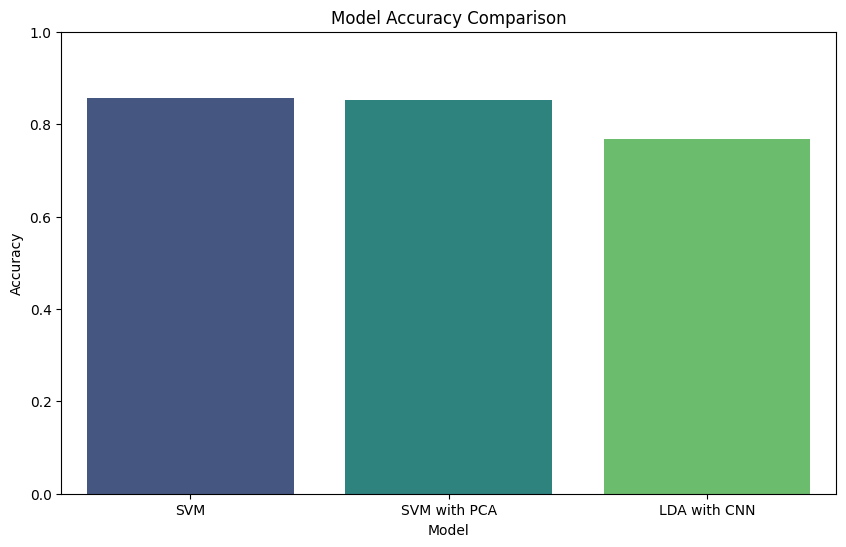

In [26]:
# Create a DataFrame for easy plotting
accuracy_data = {
    'Model': ['SVM', 'SVM with PCA', 'LDA with CNN'],
    'Accuracy': [accuracy_svm, accuracy_svm_pca, accuracy_lda]
}

accuracy_df = pd.DataFrame(accuracy_data)

# Plot the accuracies
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=accuracy_df, palette='viridis')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.ylim(0, 1)  # Set y-axis range to [0, 1] for better comparison
plt.show()


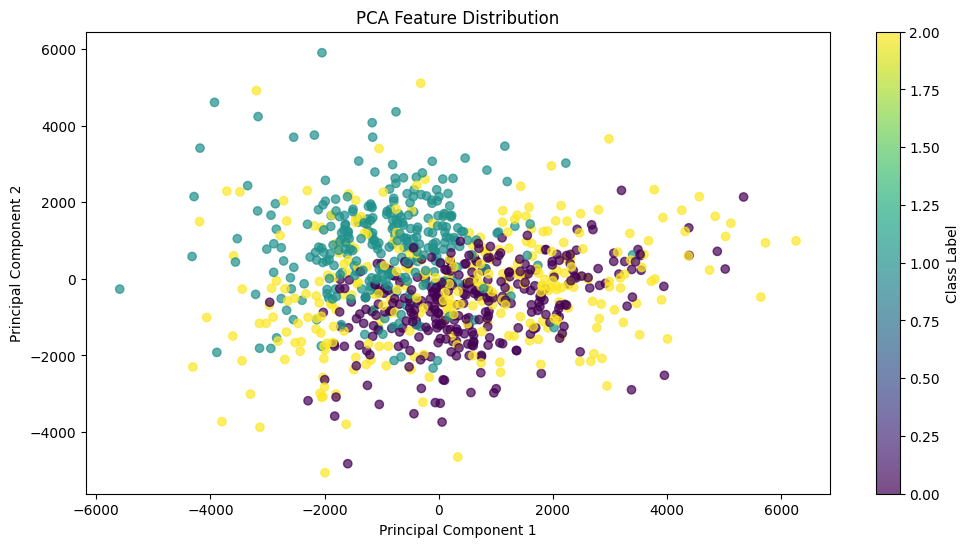

In [28]:
# Assuming X_train_pca is the PCA-transformed data
plt.figure(figsize=(12, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', alpha=0.7)
plt.colorbar(label='Class Label')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Feature Distribution')
plt.show()


In [31]:
def filter_class(images, labels, class_name, label_encoder):
    class_index = label_encoder.transform([class_name])[0]
    class_images = images[labels == class_index]
    return class_images

# Filter images for 'Rust' and 'Powdery'
rust_images = filter_class(images, labels, 'Rust', label_encoder)
powdery_images = filter_class(images, labels, 'Powdery', label_encoder)
healthy_images = filter_class(images, labels, 'Healthy', label_encoder)

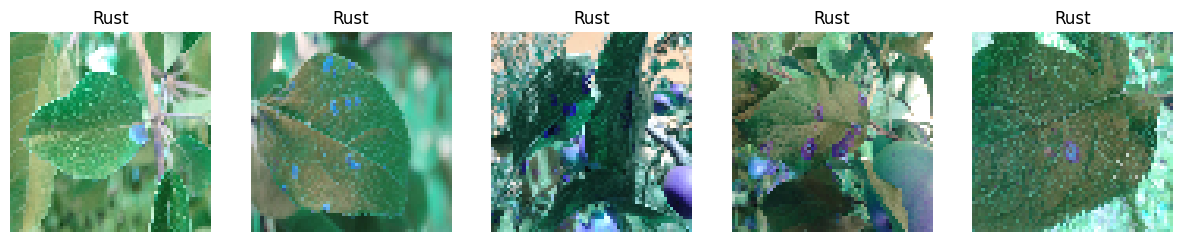

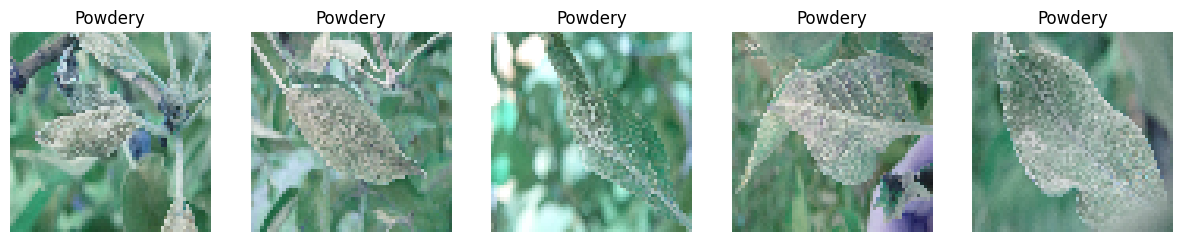

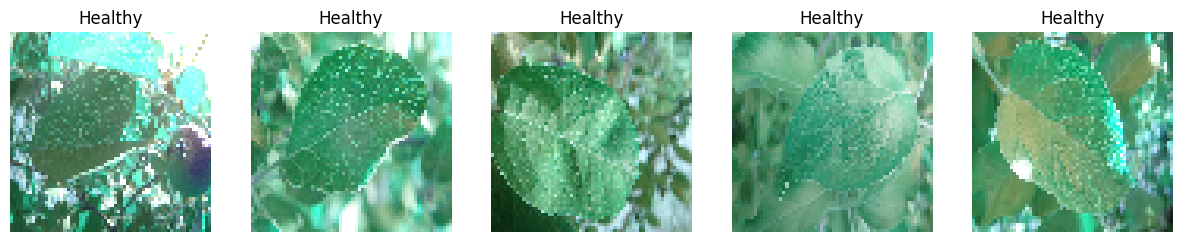

In [35]:
# Plot images for a specific class
def plot_images(images, class_name, num_images=5):
    plt.figure(figsize=(15, 10))
    for i in range(min(num_images, len(images))):  # Ensure not to exceed the number of available images
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.title(class_name)
        plt.axis('off')
    plt.show()

# Example usage
plot_images(rust_images, 'Rust', num_images=5)
plot_images(powdery_images, 'Powdery', num_images=5)
plot_images(healthy_images, 'Healthy', num_images=5)

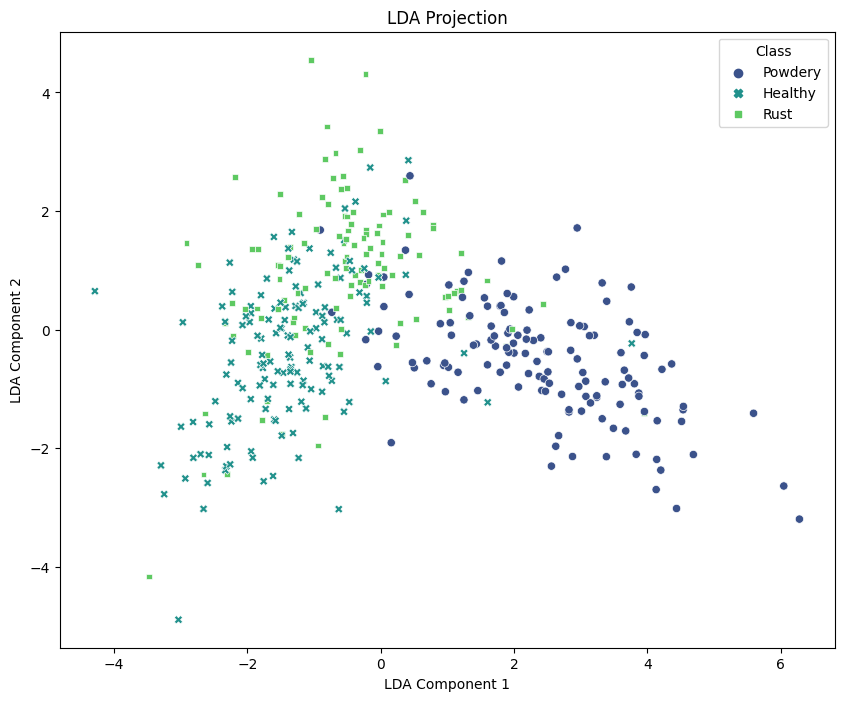

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_lda_results(X_lda, y, class_names):
    plt.figure(figsize=(10, 8))
    # Create a DataFrame for better plotting with seaborn
    lda_df = pd.DataFrame(data=X_lda, columns=['LD1', 'LD2'])
    lda_df['Label'] = y

    # Map numerical labels to class names for plotting
    lda_df['Class'] = lda_df['Label'].apply(lambda x: class_names[x])

    # Plot
    sns.scatterplot(data=lda_df, x='LD1', y='LD2', hue='Class', palette='viridis', style='Class')
    plt.title('LDA Projection')
    plt.xlabel('LDA Component 1')
    plt.ylabel('LDA Component 2')
    plt.legend(title='Class')
    plt.show()

# Example usage
plot_lda_results(X_test_lda, y_test_cnn, label_encoder.classes_)
